## Note: This notebook will use more than 2G of memory, you might want to use your own laptop

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.spatial
from sklearn.cluster import KMeans
import ray
from utils import timeit
import time


ray.init(
    num_cpus=8, # We will be using 8 workers
    include_webui=False,  
    plasma_directory='/tmp', # The object store is mounted to local file system
    ignore_reinit_error=True,
    object_store_memory=int(2*1e9), 
)



2019-04-25 18:09:32,303	INFO node.py:423 -- Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-04-25_18-09-32_643/logs.
2019-04-25 18:09:32,414	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:37762 to respond...
2019-04-25 18:09:32,545	INFO services.py:363 -- Waiting for redis server at 127.0.0.1:58264 to respond...
2019-04-25 18:09:32,550	INFO services.py:760 -- Starting Redis shard with 0.43 GB max memory.
2019-04-25 18:09:32,590	WARNING services.py:1272 -- WARNING: object_store_memory is not verified when plasma_directory is set.
2019-04-25 18:09:32,593	INFO services.py:1384 -- Starting the Plasma object store with 2.0 GB memory using /tmp.


{'node_ip_address': None,
 'redis_address': '10.244.5.91:37762',
 'object_store_address': '/tmp/ray/session_2019-04-25_18-09-32_643/sockets/plasma_store',
 'webui_url': None,
 'raylet_socket_name': '/tmp/ray/session_2019-04-25_18-09-32_643/sockets/raylet'}

## 8: Distributed K-means Clustering

Let's parallelize an algorithm designed to find clusters of data.

[*K-means*](https://en.wikipedia.org/wiki/K-means_clustering) is an unsupervised algorithm that partitions $n$ data points into $k$ clusters where each data point belongs to the cluster with the nearest mean data point or *centroid*.

The algorithm works as follows:
1. Initialize the centroids $c_1, \dots, c_k$ randomly.
2. Assign each data point $d_j$ to the cluster belonging to the closest centroid. In mathematical terms, generate sets $S_1, \dots S_k$ s.t.
$S_i = \{d_j : || d_j - c_i || < || d_j - c_l || \quad \forall j, k \quad 1 \leq j \leq n \quad 1 \leq l \leq k \}$
3. Calculate $c_1', \dots, c_k'$ s.t. $c_i' \leftarrow \text{mean}(S_i)$.
4. If none of the centroids change, finish! In other words, $c_1 = c_1' \cap \dots \cap c_k = c_k'$. 
Then, $c_1', \dots, c_k'$ are the centroids of the clusters defined by $S_1, \dots S_k$.
5. Otherwise, assign $c_1 \leftarrow c_1', \dots, c_k \leftarrow c_k'$.
6. Return to step 2.

For our purposes, we'll make a small modification to the algorithm. Instead of assigning each data point to a set 
$S_i$ and then computing $c_i' \leftarrow \text{mean}(S_i)$, we'll only store the number of data points and the sum of the data points in each cluster.
This allows us to compute the mean centroid because:

$$\text{mean}(S_i) = \frac{\text{sum}(S_i)}{|S_i|}$$

$|S_i|$ corresponds to the number of data points in cluster $i$. $\text{sum}(S_i) = \sum_{d \in S_i} d$ corresponds to the sum of the data points in cluster $i$.


Here's some additional explanations that you might find useful:
- [K-means on Wikipedia](https://en.wikipedia.org/wiki/K-means_clustering)
- [Stanford CS221 on K-means](http://stanford.edu/~cpiech/cs221/handouts/kmeans.html)
- [Visualing K-means](http://tech.nitoyon.com/en/blog/2013/11/07/k-means/)


Familliarize yourself with the non-parallel k-means implementation below.

In [2]:
def generate_centroid():
    """Generates a random centroid"""
    return np.random.random(size=2)


def generate_samples(num_samples, num_clusters, std=0.1):
    """Generates samples for some number of cluster according to a normal distribution"""
    centroids = [generate_centroid() for _ in range(num_clusters)]
    
    samples = []
    for i, centroid in enumerate(centroids):
        current_num_samples = num_samples // num_clusters
        if i == 0:
            current_num_samples += num_samples % num_clusters
        
        generated_samples = np.random.normal(centroid, std, (current_num_samples, 2))
        samples.append(generated_samples)
        
    samples = np.concatenate(samples)
    np.random.shuffle(samples)  # Occurs in-place
    return samples

NUM_CLUSTERS = 4
NUM_SAMPLES = 1000
samples = generate_samples(NUM_SAMPLES, NUM_CLUSTERS, 0.05)

In [3]:
def k_means_serial(samples, num_clusters):
    """Finds num_clusters centroids for the samples using k-means"""
    np.random.seed(0)  # Generate centroids in a predictable way so k-means runs deterministically
    centroids = [generate_centroid() for _ in range(num_clusters)]
    
    old_centroids = []
    while not np.array_equal(centroids, old_centroids):
        sums = [0 for _ in range(num_clusters)]
        counts = [0 for _ in range(num_clusters)]
        # Classify the samples
        for sample in samples:
            cluster = 0
            min_dist = np.linalg.norm(sample - centroids[0])
            
            for i, centroid in zip(range(1, num_clusters), centroids[1:]):
                dist = np.linalg.norm(sample - centroid)
                if dist < min_dist:
                    cluster = i
                    min_dist = dist
            # Record the sums and counts to later compute the new centroids
            sums[cluster] += sample
            counts[cluster] += 1
        
        old_centroids = centroids
        centroids = [s / count if count > 0 else generate_centroid() for s, count in zip(sums, counts)]
                        
    np.random.seed(None)  # Reset random seed
        
    return centroids

In [4]:
start = time.time()
serial_centroids = k_means_serial(samples, NUM_CLUSTERS)
k_means_serial_time = time.time() - start
print("k_means_serial took {} seconds.".format(k_means_serial_time))

k_means_serial took 1.0097746849060059 seconds.


### Question 8

Now, let's parallelize the k-means algorithm above. Once again, we'll parallelize the `for` loop in `k_means_serial` and parallelize the classification of data points. Classifying a single data point is very fast -- faster than the overhead needed to start a remote function. In this case, parallelizing across individual data points doesn't make sense. Instead, we'll parallelize across *batches* of data points -- larger sets of data points that are still smaller than the overall dataset.

**HINT:** use the MapReduce API.

In [5]:
def map_parallel(function, arglist):
    """Apply a function to each element of a list in parallel.
    Args:
        function: a remote function that takes in one argument as input and outputs an ObjectID
        arglist: a list of arguments that the function will be applied to
    Returns:
        A list of ObjectIDs
    """
    if not isinstance(arglist, list):
        raise ValueError("The arglist argument must be a list.")
    
    if not hasattr(function, "remote"):
        raise ValueError("The function argument must be a remote function.")
            
    # BEGIN SOLUTION
    return [function.remote(arg) for arg in arglist]
    # END SOLUTION

def reduce_parallel(function, items):
    """Apply a function repeatedly to pairs of items until only 1 remains.
    
    Args:
        function: remote function that takes 2 items as input and returns 1 new item.
        items: a list of items which are reduced to 1 output by repeatedly calling function.
    
    Returns an ObjectID.
    
    Hint:
        1. Divide the list of items into pairs.
        2. Reduce each pair to generate a new list of items.
        3. If there was an unpaired item in (1), add it to the new list.
        The new list should be about 1/2 the size of the old list.
        4. If there is only 1 item in the new list, return that item. Otherwise, repeat steps 1-3.
        
        This algorithm is called a "tree-reduce", where the original items are the leaves
        and the final result is the root. The tree is balanced. Each non-leaf node has 2 child nodes.
        Each non-root node has 1 parent node.
    """
    if not isinstance(items, list):
        raise ValueError("The items argument must be a list.")

    if not hasattr(function, "remote"):
        raise ValueError("The function argument must be a remote function.")
       
    items = items.copy()   # Avoids mutating the items argument
        
    # BEGIN SOLUTION
    if len(items) == 1:
        return ray.put(items[0])
    
    while len(items) > 1:
        a = items.pop(0)
        b = items.pop(0)
        
        oid = function.remote(a, b)
        items.append(oid)
        
    return items[0]
    # END SOLUTION

In [6]:
def merge_dicts(a, b):
    """Merges 2 dictionaries such that the result contains keys of both a and b.
    
    If a key k is in a and in b, result[k] = a[k] + b[k].
    """
    result = a.copy()  # Don't mutate the input dictionaries
    for key, value in b.items():
        result[key] = result.get(key, 0) + value
        
    return result


@ray.remote
def merge_dicts_remote(a, b):
    return merge_dicts(a, b)

In [7]:
def make_remote_batch_classifier(centroids):
    """Returns a remote function that classifies each data point in a batch"""
    @ray.remote
    def classify_remote(samples):
        """Classifies each data point in the batch.
        
        Returns a dictionary containing the sum and number of data points in the batch for each cluster.
        """
        data = {}
        
        for sample in samples:
            cluster = 0            
            # YOUR CODE HERE: classify the data point by assigning `cluster` to the cluster number
            # that the data point belongs to.
            ### BEGIN SOLUTION
            min_dist = np.linalg.norm(sample - centroids[0])
            for i, centroid in zip(range(1, len(centroids)), centroids[1:]):
                dist = np.linalg.norm(sample - centroid)
                if dist < min_dist:
                    cluster = i
                    min_dist = dist
            ### END SOLUTION
            
            sum_key = "{}_sum".format(cluster)
            count_key = "{}_count".format(cluster)
            data[sum_key] = data.get(sum_key, 0) + sample
            data[count_key] = data.get(count_key, 0) + 1
            
        return data
    
    return classify_remote


def k_means_parallel(samples, num_clusters):
    """Finds num_clusters centroids for the samples using parallelize k-means"""
    np.random.seed(0)  # Generate centroids in a predictable way so k-means runs deterministically
    centroids = [generate_centroid() for _ in range(num_clusters)]
    
    num_batches = int(ray.global_state.cluster_resources()["CPU"])
    
    # YOUR CODE HERE: Divide samples into `num_batches` batches.
    # Make sure batch sizes are roughly similar
    batches = ...
    ### BEGIN SOLUTION
    batches = np.array_split(samples, num_batches)
    ### END SOLUTION
    
    # YOUR CODE HERE: `ray.put` each batch. This eliminates overhead of repeatedly copying
    # batches to Ray's object store when calling remote functions on a batch
    batch_ids = ...
    ### BEGIN SOLUTION
    batch_ids = [ray.put(batch) for batch in batches]
    ### END SOLUTION
    
    old_centroids = []
    while not np.array_equal(centroids, old_centroids):
        remote_classifier = make_remote_batch_classifier(centroids)
        
        # YOUR CODE HERE: Classify each batch in parallel using `remote_classifier`
        batch_info_dicts_ids = ...
        ### BEGIN SOLUTION
        batch_info_dict_ids = map_parallel(remote_classifier, batch_ids)
        ### END SOLUTION
        
        # YOUR CODE HERE: use `merge_dicts_remote` to merge all batch_dict_ids into 1 dictionary 
        centroid_info = ...
        ### BEGIN SOLUTION
        centroid_info = ray.get(reduce_parallel(merge_dicts_remote, batch_info_dict_ids))
        ### END SOLUTION
        
        old_centroids = centroids
        centroids = []
        for i in range(num_clusters):
            sum_key = "{}_sum".format(i)
            count_key = "{}_count".format(i)
            cluster_sum = centroid_info.get(sum_key, 0)
            cluster_count = centroid_info.get(count_key, 0)
            if cluster_count == 0:
                new_centroid = generate_centroid()
            else:
                # YOUR CODE HERE: compute the new centroid
                new_centroid = ...
                ### BEGIN SOLUTION
                new_centroid = cluster_sum / cluster_count
                ### END SOLUTION
            
            centroids.append(new_centroid)
            
    np.random.seed(None)  # Reset the random seed
            
    return centroids

In [8]:
start = time.time()
centroids = k_means_parallel(samples, NUM_CLUSTERS)
k_means_parallel_time = time.time() - start
print("k_means_parallel took {} seconds.".format(k_means_parallel_time))
# assert np.allclose(serial_centroids, centroids)  # np.allclose avoids floating point issues

k_means_parallel took 0.6654129028320312 seconds.


You may observe that the serial code runs faster than the parallel code. In this case, the slowdown for the parallel code is likely due to overhead in running remote functions and serializing data.

Because k-means initializes centroids randomly, the number of loop iterations to converge on the final set of centroids may vary. This means that running k-means multiple times on the same dataset could take different amounts of time. This should not cause any issues on this homework because we set the random seed to deterministically initialize centroids.

Let's try k-means on a 5x larger dataset -- 5000 data points instead of 1000. The performance gain from parallelizing k-means should outweigh the overhead and parallel k-means should run faster.

In [9]:
# Run on a large dataset. This might take up to a minute.
NUM_SAMPLES = 5000
samples = generate_samples(NUM_SAMPLES, NUM_CLUSTERS, 0.05)

start = time.time()
serial_centroids = k_means_serial(samples, NUM_CLUSTERS)
k_means_serial_time = time.time() - start

start = time.time()
centroids = k_means_parallel(samples, NUM_CLUSTERS)
k_means_parallel_time = time.time() - start

print("k_means_serial took {} seconds.".format(k_means_serial_time))
print("k_means_parallel took {} seconds.".format(k_means_parallel_time))

k_means_serial took 0.7014753818511963 seconds.
k_means_parallel took 0.6380980014801025 seconds.


The parallel version of K-means should run much faster.

Now, let's visualize the cluster centers you found!

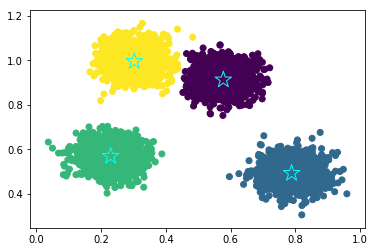

In [10]:
centroids_array = np.array(centroids)

# Label each sample based on which centroid is closest
labels = [np.argmin(np.linalg.norm(sample - centroids_array, axis=1)) for sample in samples]

# Plot results
plt.scatter(samples[:, 0], samples[:, 1], c=labels)
plt.scatter(centroids_array[:, 0], centroids_array[:, 1], c=range(len(centroids)),
            marker="*", s=300, edgecolor="cyan")

## 9: Distributed Hyperparameter Tuning

### Why Tune Hyperparameters?

Earlier in the class, you learned how to fit a function to data using techniques such as least squares. Before fitting the function to data, you'll often have to make choices about the type and configuration of the function you'd like to fit. **Hyperparameter tuning** is the problem of making good choices about the type and configuration of functions that we'll try to fit to the data. For example, consider the plot below.

By inspecting the plot, we can conclude that a cubic function will likely fit the data well. The type of function (polynomial) and the degree of the polynomial (3) are our chosen hyperparamters. While data visualization often helps choose good hyperparameters, it might not always be possible, or you might want to use an algorithm to automatically tune hyperparamters.

### Grid Search: A Basic Hyperparameter Tuning Algorithm

Grid Search is one way to find good hyperparameters. The algorithm iterates over a set of hyperparameters, and tries out each possible hyperparameter. By evaluating each hyperparameter choice, we can choose which hyperparameter works best.

First, we generate the data and split the data into a training and test set. Because functions might overfit to the training set, we'll use the test set for evaluation

In [11]:
# The "true" function that generates the data
f = lambda x: (x - 3) * (x - 1) * (x + 2)

# Generate data set
x = np.arange(-5, 5, .1)
y = f(x) + 10 * np.random.randn(*x.shape)

# Split data into training and test sets
idxs = np.random.choice(len(y), len(y), replace=False)
cutoff = (len(y) * 7) // 10
train_x, train_y = x[idxs[:cutoff]], y[idxs[:cutoff]]
test_x, test_y = x[idxs[cutoff:]], y[idxs[cutoff:]]

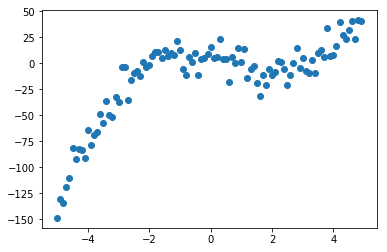

In [12]:
plt.scatter(x, y)

Next, we define the function `fit` which fits a polynomial of a certain degree to the data.

In [13]:
def fit(x, y, degree):
    """Fits a polynomial to the data"""
    z = np.polyfit(x, y, degree)
    return np.poly1d(z)

### Question 9a

Fit polynomials of degree 0 to 9 to the training data and store these functions in a list.

In [14]:
# YOUR CORE HERE:
functions = [...]

### BEGIN SOLUTION ###
functions = [fit(train_x, train_y, degree) for degree in range(10)]
### END SOLUTION ###

In [15]:
assert len(functions) == 10
for i, g in enumerate(functions):
    assert len(g.coefficients) == i + 1

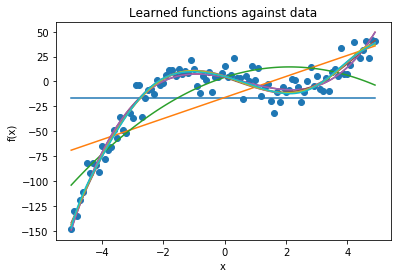

In [16]:
# Plot the learned functions against the data
plt.scatter(x, y)

plt.title("Learned functions against data")
plt.xlabel("x")
plt.ylabel("f(x)")

### YOUR CODE HERE: Plot the learned functions against x

### BEGIN SOLUTION ###
for g in functions:
    plt.plot(x, g(x))
### END SOLUTION ###

### Question 9b

We need some kind of metric to evaluate the functions. Let's use the concept of error: we define error as the distance between the output of your learned function and the true value.

Mathematically, let's define the error as:
$$\epsilon = \sum_{i=i}^n | y_i - g(x_i) | $$
where $g$ one of your learned functions.

The **training error** is the error on the data used to learn the functions.

The **test error** is the error on the data not used to learn the functions.

Find the training error and the test error for each of your learned functions.

In [17]:
training_errors = []
test_errors = []

# YOUR CODE HERE: find the training error and test error for each learned function
# and add them to lists.

### BEGIN SOLUTION ###
for g in functions:
    training_error = sum(abs(train_y - g(train_x)))
    training_errors.append(training_error)
    
    test_error = sum(abs(test_y - g(test_x)))
    test_errors.append(test_error)
### END SOLUTION ###

In [18]:
assert len(training_errors) == 10
assert len(test_errors) == 10

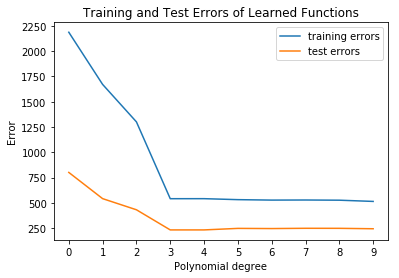

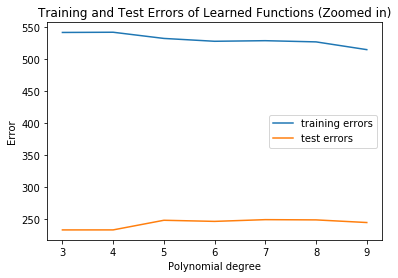

In [19]:
plt.plot(range(len(training_errors)), training_errors, label="training errors")
plt.plot(range(len(test_errors)), test_errors, label="test errors")
plt.legend()
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.xticks(range(0, 10))
plt.title("Training and Test Errors of Learned Functions")

plt.show()

plt.plot(range(3, len(training_errors)), training_errors[3:], label="training errors")
plt.plot(range(3, len(test_errors)), test_errors[3:], label="test errors")

plt.legend()
plt.xlabel("Polynomial degree")
plt.ylabel("Error")
plt.title("Training and Test Errors of Learned Functions (Zoomed in)")

plt.show()

### Question 9c

What's the degree of the best function? Use the graph above to justify. Does this match the degree of the original function `f`? Why or why not?

YOUR ANSWER HERE

### Distributed Hyperparameter Tuning

Fitting polynomials to this small amount of training data is pretty fast. Let's try something more complicated, like finding cluster centers using k-means.

K-means is an unsupervised machine learning framework. The algorithm takes the number of clusters (this is a hyperparameter) and a set of points and outputs possible cluster centers.

First, let's generate a large data set.

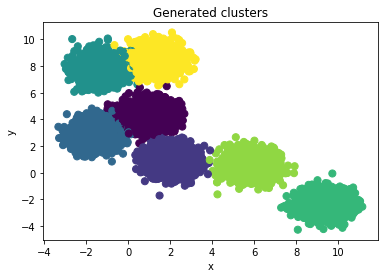

In [20]:
from sklearn.datasets.samples_generator import make_blobs

# Generate data set
points, labels = make_blobs(n_samples=10**6, centers=7,
                       cluster_std=0.60, random_state=0)

# Split into training and test sets
training_set = points[:len(points) * 7 // 10]
test_set = points[len(points) * 7 // 10:]

# Plot a few of the points...plotting all is slow.
plt.xlabel("x")
plt.ylabel("y")
plt.title("Generated clusters")
plt.scatter(points[:10000, 0], points[:10000, 1], s=50, c=labels[:10000])

### Question 9d

Use the function `k_means_serial` below to do a grid search across the number of clusters, from 1 to 10. This will take a few minutes to run.

**Remember to use the `training_set` to train your models!**

In [21]:
def k_means_serial(num_clusters, data):
    k_means = KMeans(n_clusters=num_clusters)
    k_means.fit(data)
    return k_means

In [22]:
start = time.time()
# YOUR CODE HERE: implement a grid search across the number of clusters from 1 to 10.
k_means_serial_models = [...]

### BEGIN SOLUTION ###
k_means_serial_models = [k_means_serial(num_clusters, training_set) for num_clusters in range(1, 11)]
### END SOLUTION ###

serial_hp_search_time = time.time() - start
print("Serial k-means hyperparameter search took {:.2f} seconds".format(serial_hp_search_time))

Serial k-means hyperparameter search took 87.15 seconds


In [23]:
assert len(k_means_serial_models) == 10
assert serial_hp_search_time > 1, "Something might have gone wrong...this should take longer"

### Question 9e

Now let's speed up the hyperparameter search using Ray. Turn the `k_means_parallel` function into a remote task, and use it to run multiple k-means hyperparameter configurations in parallel.

In [24]:
# YOUR CODE HERE: convert k_means_parallel into a remote task

def k_means_parallel(num_clusters, data):
    k_means = KMeans(n_clusters=num_clusters)
    k_means.fit(data)
    return k_means

### BEGIN SOLUTION ###
@ray.remote
def k_means_parallel(num_clusters, data):
    k_means = KMeans(n_clusters=num_clusters)
    k_means.fit(data)
    return k_means
### END SOLUTION ###

In [ ]:
start = time.time()
# YOUR CODE HERE: implement a parallel grid search across the number of clusters from 1 to 10
k_means_parallel_models = ...

### BEGIN SOLUTION ###
# Serializing training_set once might offer a speedup. This is a best practice; not necessary in student solution.
training_set_id = ray.put(training_set)
k_means_parallel_models = ray.get(
    [k_means_parallel.remote(num_clusters, training_set_id) for num_clusters in range(1, 11)])
### END SOLUTION ###

parallel_hp_search_time = time.time() - start
print("Parallel k-means hyperparameter search took {:.2f} seconds".format(parallel_hp_search_time))

In [ ]:
assert len(k_means_parallel_models) == 10
assert all([not isinstance(i, ray.ObjectID) for i in k_means_parallel_models]), "Don't forget to call ray.get!"
assert parallel_hp_search_time < 0.75 * serial_hp_search_time

### Question 9f

Finally, find the training and test errors for each k-means model.

Hint: the k-means models have a `score(dataset)` method which returns the model's score on the dataset (larger values are better).
For example, `k_means_parallel_models[0].score(training_set)` would return the score for the 0th k-means model on the training set.

In [ ]:
# YOUR CODE HERE: compute the training cost and the 
training_scores = [...]
test_scores = [...]

### BEGIN SOLUTION ###
training_scores = [model.score(training_set) for model in k_means_parallel_models]
test_scores = [model.score(test_set) for model in k_means_parallel_models]
### END SOLUTION ###

In [ ]:
plt.plot(range(len(training_scores)), training_scores, label="training scores")
plt.plot(range(len(test_scores)), test_scores, label="test scores")
plt.legend()
plt.xlabel("Number of clusters")
plt.ylabel("Score")
plt.xticks(range(0, 10))
plt.title("Training and Test Scores of Learned Models")

plt.show()

plt.plot(range(3, len(training_errors)), training_errors[3:], label="training errors")
plt.plot(range(3, len(test_errors)), test_errors[3:], label="test errors")

plt.legend()
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.title("Training and Test Scores of Learned Models (Zoomed in)")

plt.show()

### Question 9g

What's the number of clusters should you choose? Use the graph above to justify. Does this match the number of clusters used to generate the data? Why or why not?

YOUR ANSWER HERE

In [ ]:
# Plots labeled clusters for each model
plt.figure(figsize=(12, 12))
plt.suptitle("Cluster Classification for K-Means Models with different Numbers of Clusters")
samples = points[:1000] # Plot only a small sample of the points due to speed of plotting
for i, model in enumerate(k_means_parallel_models):
    plt.subplot(4, 3, i + 1)
    plt.title("{} Centers".format(i + 1))
    labels = model.predict(samples)
    plt.scatter(samples[:, 0], samples[:, 1], c=labels)
    
    centroids = model.cluster_centers_
    plt.scatter(centroids[:, 0], centroids[:, 1], c=range(len(centroids)), marker="*", s=300, edgecolor="cyan")